In [1]:
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.spatial.transform import Rotation as R


def transform_imu_to_world(imu_coordinates, imu_quaternions):
    # This array contains a timeseries of transformation matrices,
    # as calculated from the IMU's timeseries of quaternions values.
    imu_to_world_matrices = R.from_quat(imu_quaternions).as_matrix()

    if np.ndim(imu_coordinates) == 1:
        return imu_to_world_matrices @ imu_coordinates
    else:
        return np.array(
            [
                imu_to_world @ imu_coord
                for imu_to_world, imu_coord in zip(
                    imu_to_world_matrices, imu_coordinates
                )
            ]
        )


def transform_scene_to_imu(
    coords_in_scene, translation_in_imu=np.array([0.0, -1.3, -6.62])
):
    imu_scene_rotation_diff = np.deg2rad(-90 - 12)
    scene_to_imu = np.array(
        [
            [1.0, 0.0, 0.0],
            [
                0.0,
                np.cos(imu_scene_rotation_diff),
                -np.sin(imu_scene_rotation_diff),
            ],
            [
                0.0,
                np.sin(imu_scene_rotation_diff),
                np.cos(imu_scene_rotation_diff),
            ],
        ]
    )

    coords_in_imu = scene_to_imu @ coords_in_scene.T

    coords_in_imu[0, :] += translation_in_imu[0]
    coords_in_imu[1, :] += translation_in_imu[1]
    coords_in_imu[2, :] += translation_in_imu[2]

    return coords_in_imu.T


def spherical_to_cartesian_scene(elevations, azimuths):
    """
    Convert Neon's spherical representation of 3D gaze to Cartesian coordinates.
    """

    elevations_rad = np.deg2rad(elevations)
    azimuths_rad = np.deg2rad(azimuths)

    # Elevation of 0 in Neon system corresponds to Y = 0, but
    # an elevation of 0 in traditional spherical coordinates would
    # correspond to Y = 1, so we convert elevation to the
    # more traditional format.
    elevations_rad += np.pi / 2

    # Azimuth of 0 in Neon system corresponds to X = 0, but
    # an azimuth of 0 in traditional spherical coordinates would
    # correspond to X = 1. Also, azimuth to the right in Neon is
    # more positive, whereas it is more negative in traditional
    # spherical coordiantes. So, we convert azimuth to the more
    # traditional format.
    azimuths_rad *= -1.0
    azimuths_rad += np.pi / 2

    return np.array(
        [
            np.sin(elevations_rad) * np.cos(azimuths_rad),
            np.cos(elevations_rad),
            np.sin(elevations_rad) * np.sin(azimuths_rad),
        ]
    ).T


def transform_scene_to_world(
    coords_in_scene, imu_quaternions, translation_in_imu=np.array([0.0, -1.3, -6.62])
):
    coords_in_imu = transform_scene_to_imu(coords_in_scene, translation_in_imu)
    return transform_imu_to_world(coords_in_imu, imu_quaternions)


def gaze_3d_to_world(gaze_elevation, gaze_azimuth, imu_quaternions):
    cart_gazes_in_scene = spherical_to_cartesian_scene(gaze_elevation, gaze_azimuth)
    return transform_scene_to_world(
        cart_gazes_in_scene, imu_quaternions, translation_in_imu=np.zeros(3)
    )


def imu_heading_in_world(imu_quaternions):
    heading_neutral_in_imu_coords = np.array([0.0, 1.0, 0.0])
    return transform_imu_to_world(heading_neutral_in_imu_coords, imu_quaternions)

In [3]:
rec_dir = "./2024-08-19_14-20-57-48fd6838/"

gaze = pd.read_csv(rec_dir + "gaze.csv")
eye3d = pd.read_csv(rec_dir + "3d_eye_states.csv")
imu = pd.read_csv(rec_dir + "imu.csv")
world = pd.read_csv(rec_dir + "world_timestamps.csv")

gaze_ts = gaze["timestamp [ns]"]
imu_ts = imu["timestamp [ns]"]
world_ts = world["timestamp [ns]"]

info = []
with open(rec_dir + "info.json", "r") as f:
    info = json.load(f)

gaze["relative ts [s]"] = (gaze_ts - info["start_time"]) * 1e-9
imu["relative ts [s]"] = (imu_ts - info["start_time"]) * 1e-9
world["relative ts [s]"] = (world_ts - info["start_time"]) * 1e-9

relative_demo_video_ts = np.arange(
    world["relative ts [s]"].iloc[200], world["relative ts [s]"].iloc[-100], 1/30
)

# We have more gaze datapoints (sampled at 200Hz) than
# IMU datapoints (sampled at 110Hz). We also need to sample values at the
# framerate of the visualization video that we will make, so linearly
# interpolate the IMU and gaze datapoints to be congruent with each other
# and the video render.
quaternions_resampled = np.array(
    [
        np.interp(relative_demo_video_ts, imu["relative ts [s]"], imu["quaternion x"]),
        np.interp(relative_demo_video_ts, imu["relative ts [s]"], imu["quaternion y"]),
        np.interp(relative_demo_video_ts, imu["relative ts [s]"], imu["quaternion z"]),
        np.interp(relative_demo_video_ts, imu["relative ts [s]"], imu["quaternion w"]),
    ]
).T

gaze_elevation_resampled = np.interp(relative_demo_video_ts, gaze["relative ts [s]"], gaze["elevation [deg]"])
gaze_azimuth_resampled = np.interp(relative_demo_video_ts, gaze["relative ts [s]"], gaze["azimuth [deg]"])

# Now, we can apply the functions.

headings_in_world = imu_heading_in_world(quaternions_resampled)

cart_gazes_in_world = gaze_3d_to_world(
    gaze_elevation_resampled, gaze_azimuth_resampled, quaternions_resampled
)

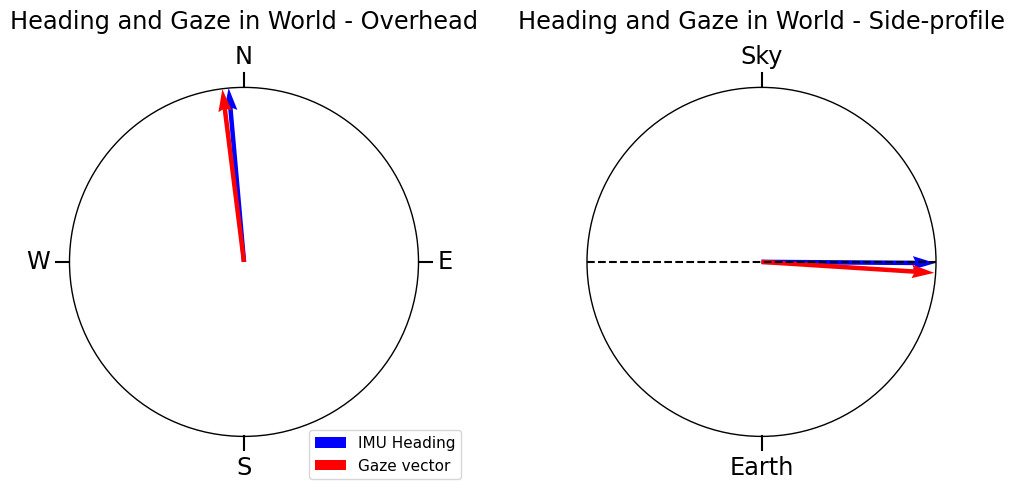

In [4]:
import matplotlib.animation as animation

fig, axs = plt.subplots(1, 2, figsize=(10.5, 5))

# Overhead visualization

axs[0].axis("square")
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlim(-1.29, 1.29)
axs[0].set_ylim(-1.29, 1.29)

axs[0].axis("off")

circle = plt.Circle((0, 0), 1.0, color="black", fill=False)
axs[0].add_patch(circle)

axs[0].text(0, 1.11, "N", ha="center", va="bottom", fontsize="xx-large")
axs[0].text(0, -1.11, "S", ha="center", va="top", fontsize="xx-large")
axs[0].text(1.11, 0, "E", ha="left", va="center", fontsize="xx-large")
axs[0].text(-1.11, 0, "W", ha="right", va="center", fontsize="xx-large")

axs[0].plot([0, 0], [1.0, 1.08], color="black")
axs[0].plot([0, 0], [-1.0, -1.08], color="black")
axs[0].plot([1.0, 1.08], [0, 0], color="black")
axs[0].plot([-1.0, -1.08], [0, 0], color="black")

heading_quiver_overhead = axs[0].quiver(
    0,
    0,
    headings_in_world[0, 0],
    headings_in_world[0, 1],
    color="b",
    label="IMU Heading",
    scale=1,
    scale_units="xy",
    angles="xy",
    width=0.01,
)

gaze_quiver_overhead = axs[0].quiver(
    0,
    0,
    cart_gazes_in_world[0, 0],
    cart_gazes_in_world[0, 1],
    color="r",
    label="Gaze vector",
    scale=1,
    scale_units="xy",
    angles="xy",
    width=0.01,
)

axs[0].legend(loc="lower right", prop={"size": 11})

axs[0].set_title("Heading and Gaze in World - Overhead", fontsize="xx-large")


# Side profile visualization

axs[1].axis("square")
axs[1].set_aspect("equal", adjustable="box")
axs[1].set_xlim(-1.29, 1.29)
axs[1].set_ylim(-1.29, 1.29)

axs[1].axis("off")

circle = plt.Circle((0, 0), 1.0, color="black", fill=False)
axs[1].add_patch(circle)

axs[1].plot([0, 0], [1.0, 1.08], color="black")
axs[1].plot([0, 0], [-1.0, -1.08], color="black")

axs[1].text(0, 1.11, "Sky", ha="center", va="bottom", fontsize="xx-large")
axs[1].text(0, -1.11, "Earth", ha="center", va="top", fontsize="xx-large")

axs[1].hlines(0, -1.0, 1.0, color="black", linestyle="--")

heading_quiver_sideprofile = axs[1].quiver(
    0,
    0,
    headings_in_world[0, 1],
    headings_in_world[0, 2],
    color="b",
    scale=1,
    scale_units="xy",
    angles="xy",
    width=0.01,
)

gaze_quiver_sideprofile = axs[1].quiver(
    0,
    0,
    cart_gazes_in_world[0, 1],
    cart_gazes_in_world[0, 2],
    color="r",
    scale=1,
    scale_units="xy",
    angles="xy",
    width=0.01,
)

axs[1].set_title("Heading and Gaze in World - Side-profile", fontsize="xx-large")


def update(frame):
    global heading_quiver_overhead
    heading_quiver_overhead.remove()
    heading_quiver_overhead = axs[0].quiver(
        0,
        0,
        headings_in_world[frame, 0],
        headings_in_world[frame, 1],
        color="b",
        label="IMU Heading",
        scale=1,
        scale_units="xy",
        angles="xy",
        width=0.01,
    )

    global gaze_quiver_overhead
    gaze_quiver_overhead.remove()
    gaze_quiver_overhead = axs[0].quiver(
        0,
        0,
        cart_gazes_in_world[frame, 0],
        cart_gazes_in_world[frame, 1],
        color="r",
        label="Gaze vector",
        scale=1,
        scale_units="xy",
        angles="xy",
        width=0.01,
    )
    
    global heading_quiver_sideprofile
    heading_quiver_sideprofile.remove()
    heading_quiver_sideprofile = axs[1].quiver(
        0,
        0,
        headings_in_world[frame, 1],
        headings_in_world[frame, 2],
        color="b",
        scale=1,
        scale_units="xy",
        angles="xy",
        width=0.01,
    )

    global gaze_quiver_sideprofile
    gaze_quiver_sideprofile.remove()
    gaze_quiver_sideprofile = axs[1].quiver(
        0,
        0,
        cart_gazes_in_world[frame, 1],
        cart_gazes_in_world[frame, 2],
        color="r",
        scale=1,
        scale_units="xy",
        angles="xy",
        width=0.01,
    )

    return


fig.tight_layout()

ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(relative_demo_video_ts), interval=33.3333333333
)
ani.save("imu_heading.mp4", writer="ffmpeg")

In [6]:
gaze_left_start = 140
head_left_start = 315
gaze_head_left_start = 515
gaze_left_end = 255
head_left_end = 460
gaze_head_left_end = 650


gaze_right_start = 1201
head_right_start = 1364
gaze_head_right_start = 1614
gaze_right_end = 1325
head_right_end = 1560
gaze_head_right_end = 1762


gaze_up_start = 690
head_up_start = 850
gaze_head_up_start = 1030
gaze_up_end = 805
head_up_end = 1005
gaze_head_up_end = 1160


gaze_down_start = 1828
head_down_start = 2028
gaze_head_down_start = 2218
gaze_down_end = 1931
head_down_end = 2155
gaze_head_down_end = 2356


free_viewing_start = 2415
free_viewing_end = len(world_ts[200:-100]) - 1

In [7]:
# The gaze+eye overlay video was made with the pl-neon-recording library:
# https://github.com/pupil-labs/pl-neon-recording
import pupil_labs.neon_recording as nr

native_rec_dir = "./native_2024-08-19_14-20-57-48fd6838/"
recording = nr.load(native_rec_dir)


def overlay_image(img, img_overlay, x, y):
    """Overlay `img_overlay` onto `img` at (x, y)."""

    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    img_crop[:] = img_overlay_crop


def overlay_text(img, x, y, text="hello!"):
    text_background = np.zeros((110, 1600, 3), dtype=np.uint8)
    text_background[:] = (255, 255, 255)

    overlay_image(img, text_background, 0, y-85)

    text_position = (x, y)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 3
    color = (0, 0, 0)
    thickness = 4
    img = cv2.putText(img, text, text_position, font, font_scale, color, thickness)
    return img


def make_overlaid_video(recording, output_video_path, fps=30):
    video_writer = cv2.VideoWriter(
        str(output_video_path),
        cv2.VideoWriter_fourcc(*"MJPG"),
        fps,
        (recording.scene.width, recording.scene.height),
    )

    output_timestamps = np.arange(
        world_ts.iloc[200] * 1e-9,
        world_ts.iloc[-100] * 1e-9,
        1 / 30,
    )

    combined_data = zip(
        recording.scene.sample(output_timestamps),
        recording.eye.sample(output_timestamps),
        recording.gaze.sample(output_timestamps),
    )

    frame_idx = 0
    for scene_frame, eye_frame, gaze_datum in combined_data:
        frame_idx += 1
        frame_pixels = scene_frame.bgr
        eye_pixels = cv2.cvtColor(eye_frame.gray, cv2.COLOR_GRAY2BGR)
        
        frame_pixels = cv2.circle(
            frame_pixels, (int(gaze_datum.x), int(gaze_datum.y)), 50, (0, 0, 255), 10
        )

        overlay_image(frame_pixels, eye_pixels, 50, 50)
        
        if frame_idx >= gaze_left_start and frame_idx <= gaze_left_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze left")
        elif frame_idx >= head_left_start and frame_idx <= head_left_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Head left")
        elif frame_idx >= gaze_head_left_start and frame_idx <= gaze_head_left_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze and head left")
        elif frame_idx >= gaze_right_start and frame_idx <= gaze_right_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze right")
        elif frame_idx >= head_right_start and frame_idx <= head_right_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Head right")
        elif frame_idx >= gaze_head_right_start and frame_idx <= gaze_head_right_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze and head right")
        elif frame_idx >= gaze_up_start and frame_idx <= gaze_up_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze up")
        elif frame_idx >= head_up_start and frame_idx <= head_up_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Head up")
        elif frame_idx >= gaze_head_up_start and frame_idx <= gaze_head_up_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze and head up")
        elif frame_idx >= gaze_down_start and frame_idx <= gaze_down_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze down")
        elif frame_idx >= head_down_start and frame_idx <= head_down_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Head down")
        elif frame_idx >= gaze_head_down_start and frame_idx <= gaze_head_down_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Gaze and head down")
        elif frame_idx >= free_viewing_start and frame_idx <= free_viewing_end:
            frame_pixels = overlay_text(frame_pixels, 100, 1100, "Free viewing")
        
        video_writer.write(frame_pixels)

    video_writer.release()


make_overlaid_video(recording, "eye-gaze-overlay-output-video.avi")